In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision.datasets import FashionMNIST
from torchvision import transforms

from random import randint
from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
t = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
dataset_train = FashionMNIST(root="../datasets/", train=True, download=True, transform=t)
dataset_test = FashionMNIST(root="../datasets/", train=False, download=True, transform=t)

100%|██████████| 26421880/26421880 [00:02<00:00, 12810153.87it/s]


Extracting ../datasets/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../datasets/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 200380.19it/s]


Extracting ../datasets/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../datasets/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3704398.91it/s]


Extracting ../datasets/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../datasets/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4232120.15it/s]

Extracting ../datasets/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../datasets/FashionMNIST/raw



In [39]:
train_dataloader = DataLoader(dataset=dataset_train, batch_size=32, shuffle=True)
test_dataloader = DataLoader(dataset=dataset_test, batch_size=10000, shuffle=False)

In [4]:
class alexnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(11, 11), stride=(4, 4)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3,3), stride=(2,2)),
            nn.Conv2d(in_channels=16, out_channels=24, kernel_size=(5,5), padding=(2,2)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3,3), stride=(2,2)),
            nn.Conv2d(in_channels=24, out_channels=32, kernel_size=(3,3), padding=(1,1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3),padding=(1,1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=24, kernel_size=(3,3), padding=(1,1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3,3), stride=(2,2)),
            nn.Flatten(),
            nn.Linear(in_features=24*5*5, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=10),
            nn.LogSoftmax(dim=1)
        )
    def forward(self, x):
        return self.layer_stack(x)

In [5]:
device = torch.device("cuda")
model = alexnet().to(device)

In [17]:
N_EPOCHS = 5

B_EPOCHS = int(60_000 / 32)

optim = torch.optim.SGD(params=model.parameters(), lr=0.01)
loss_fn = nn.NLLLoss()
def acc_fn(pred, target):
  return (pred.argmax(dim=1)==target).sum()

In [27]:
losses = []
accs = []

prog_bar = tqdm(range(N_EPOCHS))

for e in prog_bar:
  for i, (x, y) in enumerate(train_dataloader):
    optim.zero_grad()
    pred = model(x.to(device))

    loss = loss_fn(pred, y.to(device))
    losses.append(loss.item()/32)

    acc = acc_fn(pred.detach().cpu(), y.detach().cpu())
    accs.append(acc.item()/32)

    loss.backward()
    optim.step()
    prog_bar.set_description(f"Epoch: {e} --- {i}/{B_EPOCHS} --- Loss: {loss.item()/32} --- Acc: {acc.item()/32}")


Epoch: 4 --- 1874/1875 --- Loss: 0.00882261898368597 --- Acc: 0.90625: 100%|██████████| 5/5 [04:05<00:00, 49.05s/it]


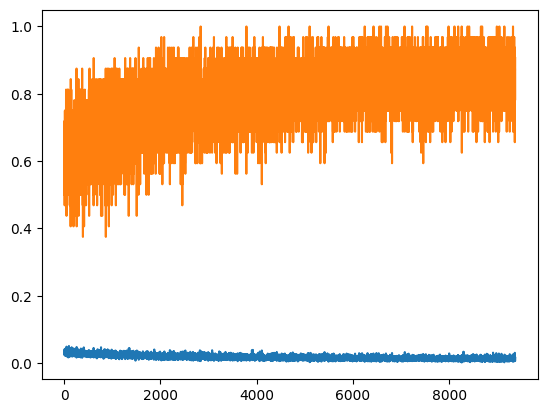

In [30]:
plt.plot(losses)
plt.plot(accs)

In [40]:
model.eval()
score = 0
for x, y in test_dataloader:
  score += acc_fn(model(x.to(device)).detach().cpu(), y)
print(score)

tensor(8571)
